<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Gain_Rheo_Anim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
import matplotlib as mpl
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl --quiet
!pip install XlsxWriter --quiet


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None

"run dtabuena's ephys notebooks"
try: shutil.rmtree('/content/CrispyMice')
except: None
# !git clone https://github.com/dtabuena/CrispyMice
# to_import = ['CrispyPipelineFuncs.ipynb']
# for i in to_import:
#     f = '/content/CrispyMice/' + i
#     %run $f
!git clone https://github.com/dtabuena/EphysLib
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',
            'Ephys_wrapper.ipynb',
            ]
for i in to_import:
    f = '/content/EphysLib/' + i
    %run $f


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.2 MB/s eta 0:00:00
Cloning into 'EphysLib'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (454/454), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 1077 (delta 330), reused 230 (delta 193), pack-reused 623
Receiving objects: 100% (1077/1077), 17.41 MiB | 16.63 MiB/s, done.
Resolving deltas: 100% (707/707), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.0 MB/s eta 0:00:00


In [2]:

import urllib.request
file_link = 'https://www.dropbox.com/scl/fi/p5vny9fsmonwbsm74a5k7/2022x10x28_NEL2_E4KI_F_P258_s001_c001_CA3xPOS_0008.abf?rlkey=xr0y9rw0dmoynnsp38idiemii&dl=1'
filename = './2022x10x28_NEL2_E4KI_F_P258_s001_c001_CA3xPOS_0008.abf'
urllib.request.urlretrieve(file_link, filename)

('./2022x10x28_NEL2_E4KI_F_P258_s001_c001_CA3xPOS_0008.abf',
 <http.client.HTTPMessage at 0x7eefac42afe0>)

In [3]:
def set_font_all(FS):

    # get arial
    import matplotlib as mpl
    import urllib.request
    arial_link = 'https://raw.githubusercontent.com/dtabuena/Resources/main/Fonts/arial.ttf'
    filename = './arial.ttf'
    urllib.request.urlretrieve(arial_link, filename)
    mpl.font_manager.fontManager.addfont(filename)

    plt.rcParams.update({'font.size': FS, 'font.family': 'arial','axes.linewidth':.5,
                         'xtick.major.width': 0.5,'ytick.major.width': 0.5,
                         'figure.titlesize':FS,'axes.titlesize': FS,'xtick.labelsize': FS,
                         'ytick.labelsize': FS,'axes.labelsize': FS,'legend.fontsize': FS})
    return None
set_font_all(8)

In [ ]:
def plot_gain_steps(abf,fig,ax,fig_name='figure',dir='multisweep',linewidth=.5):
    im_list = []
    try: os.makedirs(dir)
    except: None
    results = {}
    spike_args =  {'spike_thresh':10, 'high_dv_thresh': 25,'low_dv_thresh': -5,'window_ms': 2}
    if len(abf.sweepList)<5: return results # not enough sweeps to analyze

    # Analysis
    spike_results= spikes_per_stim(abf,spike_args, mode='count', to_plot=False)
    stim_currents = spike_results['stim_currents']
    spike_counts = spike_results['spike_counts']
    spike_rates = spike_results['spike_rates']
    v_before_stim = spike_results['v_before_stim']
    fire_dur = spike_results['fire_dur']
    isi_rates = spike_results['isi_rates']
    spike_times = spike_results['spike_times']

    rheo_ind = list(np.diff(spike_counts,prepend=0)>0).index(True)

    ## Plotting
    is_base, is_stim = protocol_baseline_and_stim(abf) # find base lines and stims
    colors = plt.cm.cividis(np.linspace(0,1,len(abf.sweepList)))
    for s in abf.sweepList:
        abf.setSweep(s)
        dim = .8
        stim_color = np.array(colors[s])*[dim,dim,dim,1]
        if s ==  rheo_ind: stim_color='r'
        time = abf.sweepX
        cmd = abf.sweepC
        memb = abf.sweepY
        memb = memb-memb[0]-70

        ax[2].plot(time,cmd,color=stim_color,linewidth=linewidth)
        ax[0].plot(time,memb,color=stim_color,linewidth=linewidth)
        ax[1].plot(stim_currents[:s+1],spike_counts[:s+1],color='k',linewidth=linewidth/1,zorder=0)
        ax[1].scatter(stim_currents[s],spike_counts[s],color=stim_color,s=6,zorder=1)
        if s ==  rheo_ind: ax[1].text(stim_currents[s],spike_counts[s],' rheobase',ha='left',va='top',color='r')

        im_loc=f'./{dir}/{fig_name}_s{s}.jpg'
        im_list.append(im_loc)
        fig.savefig(im_loc,format='jpg',dpi=300)

    return im_list

def trace_scalebar(ax=[],origin=[],x_unit=[],y_unit=[],x_len=[],y_len=[],x_rescale=1,y_rescale=1,linewidth=1,baseline=0):

    xlims=ax.get_xlim()
    ylims=ax.get_ylim()

    x_len_scaled=x_len/x_rescale
    y_len_scaled=y_len/y_rescale

    # xbar
    ax.plot([origin[0],origin[0]+x_len_scaled],[origin[1],origin[1]],'k',linewidth=linewidth)
    # text
    ax.text(origin[0]+x_len_scaled/2,origin[1]-y_len_scaled*.1, f'{x_len}{x_unit}',ha='center',va='top')

    # ybar
    ax.plot([origin[0],origin[0]],[origin[1],origin[1]+y_len_scaled],'k',linewidth=linewidth)
    # text
    ax.text(origin[0]-x_len_scaled*.1,origin[1]+y_len_scaled/2, f'{y_len}{y_unit}',ha='right',va='center',rotation=90)

    # baseline
    ax.text(ax.get_xlim()[0],baseline,f'{baseline}{y_unit}',ha='right',va='center')
    ax.axis('off')
    return None


abf = abf_or_name(filename)
fig,ax = plt.subplots(2,2,figsize=(6,5),width_ratios=(3,1.5),height_ratios=(3,1),dpi=300)
ax=ax.flatten()
ax[-1].set_visible(False)



v_range = [-80,60]
t_range = [0.1,2]
i_range = [-50,500]
f_range = [-10,60]

ax[0].set_xlim(t_range)
ax[0].set_ylim(v_range)
ax[2].set_xlim(t_range)
ax[2].set_ylim(i_range)
ax[1].set_xlim(i_range)
ax[1].set_ylim(f_range)
ax[1].set_xlabel('Stimulus (pA)')
ax[1].set_ylabel('Firing Rate (Hz)')
ax[1].set_title('Response Curve')
plt.tight_layout()

trace_scalebar(ax=ax[0],origin=[.2,-40],x_unit='ms',y_unit='mV',x_len=200,y_len=20,x_rescale=1000,baseline=-70)
trace_scalebar(ax=ax[2],origin=[.2,150],x_unit='ms',y_unit='pA',x_len=200,y_len=100,x_rescale=1000,baseline=0)

im_list = plot_gain_steps(abf,fig,ax)



plt.show()

from google.colab import files
!zip -r /content/multisweep.zip /content/multisweep
files.download('./multisweep.zip')

  adding: content/rheo/ (stored 0%)
  adding: content/rheo/rheo_s1.jpg (deflated 33%)
  adding: content/rheo/rheo_s0.jpg (deflated 76%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

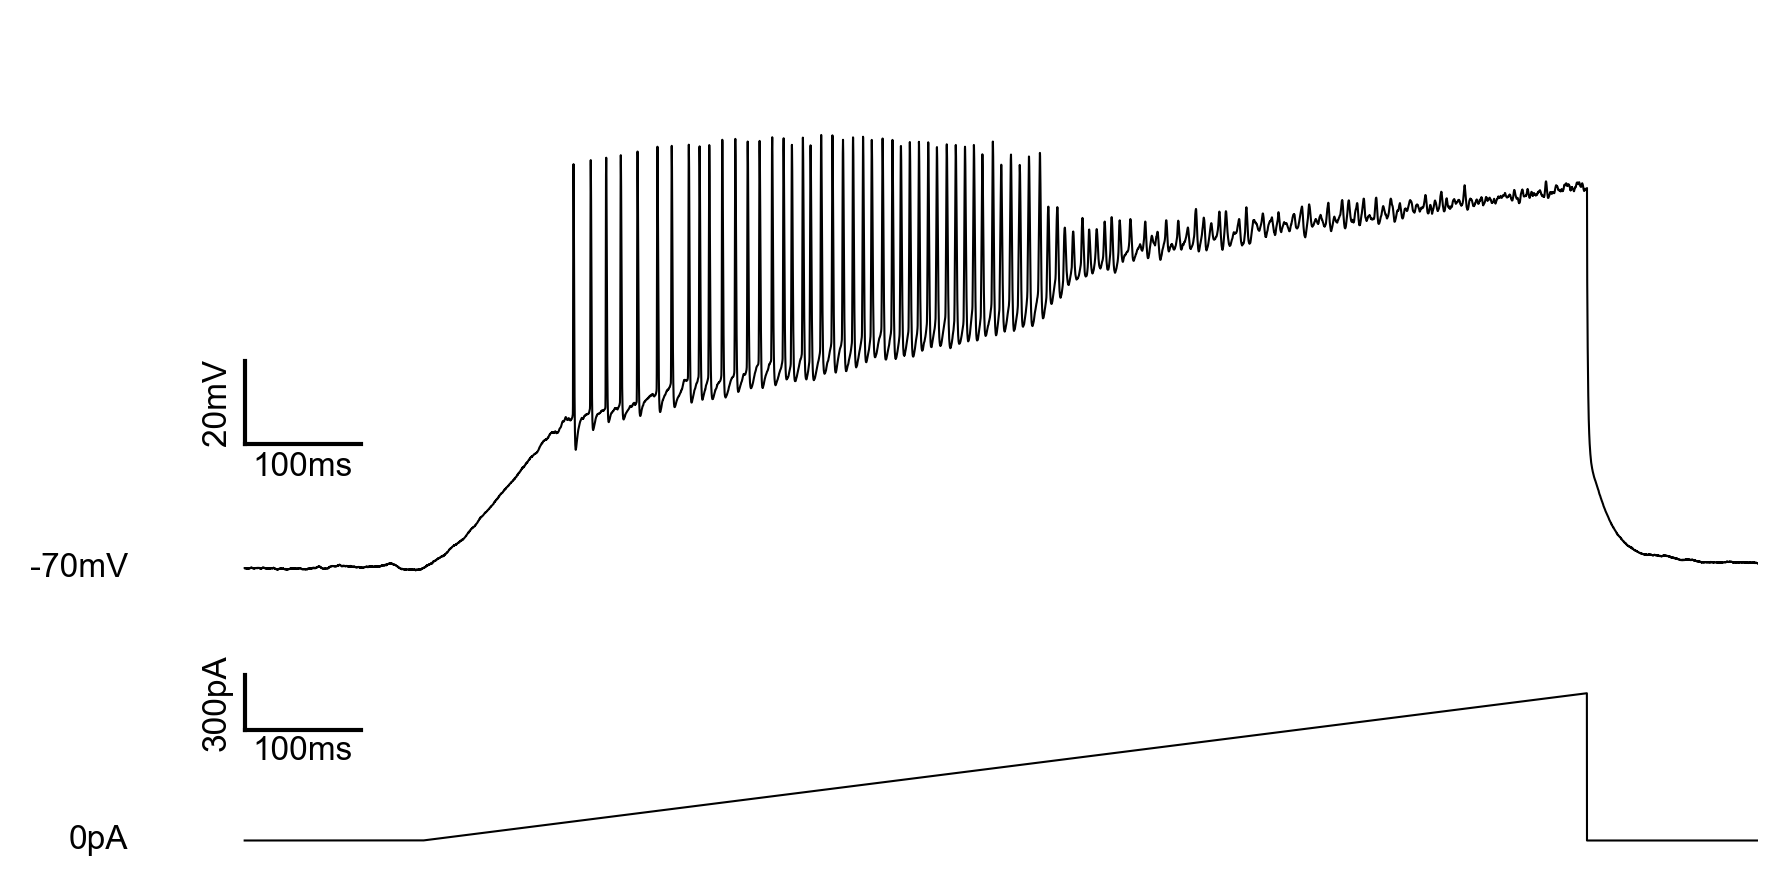

In [36]:
##### Rheobase

def latencey_sweep(abf,ax,linewidth=.5):
    spike_args =  {'spike_thresh':10, 'high_dv_thresh': 25,'low_dv_thresh': -5,'window_ms': 2}
    abf.setSweep(0,0)
    stim_color = 'k'
    time = abf.sweepX
    cmd = abf.sweepC
    memb = abf.sweepY
    memb = memb-memb[0]-70

    ax[0].plot(time,memb,color=stim_color,linewidth=linewidth)
    ax[1].plot(time,cmd,color=stim_color,linewidth=linewidth)


    return None

import urllib.request
file_link = 'https://www.dropbox.com/scl/fi/d08sjufpxcm9qvauh8jba/2022x08x10_NEL2_E4KI_F_P249_s001_c003_DGxNEG_0006.abf?rlkey=9ivm66dfcsu6atxpgkymobise&dl=1'
filename = './2022x08x10_NEL2_E4KI_F_P249_s001_c003_DGxNEG_0006.abf'
urllib.request.urlretrieve(file_link, filename)

v_range = [-80,60]
t_range = [-.1,1.3]
i_range = [-50,1000]
f_range = [-10,60]


abf = abf_or_name(filename)
fig,ax=plt.subplots(2,1,figsize=(6,3),dpi=300,height_ratios=(3,1))

ax[0].set_xlim(t_range)
ax[0].set_ylim(v_range)
ax[1].set_xlim(t_range)
ax[1].set_ylim(i_range)

# latencey_sweep(abf,ax)

trace_scalebar(ax=ax[0],origin=[0,-40],x_unit='ms',y_unit='mV',x_len=100,y_len=20,x_rescale=1000,baseline=-70)
trace_scalebar(ax=ax[1],origin=[0,600],x_unit='ms',y_unit='pA',x_len=100,y_len=300,x_rescale=1000,baseline=0)
plt.tight_layout()

dir = './rheo'
try: os.makedirs(dir)
except: None
fig_name='rheo'
fig.savefig(f'./{dir}/{fig_name}_s0.jpg')
im_loc=f'./{dir}/{fig_name}_s0.jpg'
im_list.append(im_loc)
fig.savefig(im_loc,format='jpg',dpi=300)

latencey_sweep(abf,ax)

fig.savefig(f'./{dir}/{fig_name}_s1.jpg')
im_loc=f'./{dir}/{fig_name}_s1.jpg'
im_list.append(im_loc)
fig.savefig(im_loc,format='jpg',dpi=300)


from google.colab import files
!zip -r /content/rheo.zip /content/rheo
files.download('./rheo.zip')

In [44]:
import urllib.request
file_link = 'https://www.dropbox.com/scl/fi/p5vny9fsmonwbsm74a5k7/2022x10x28_NEL2_E4KI_F_P258_s001_c001_CA3xPOS_0008.abf?rlkey=xr0y9rw0dmoynnsp38idiemii&dl=1'
filename = './2022x10x28_NEL2_E4KI_F_P258_s001_c001_CA3xPOS_0008.abf'
urllib.request.urlretrieve(file_link, filename)

('./2022x10x28_NEL2_E4KI_F_P258_s001_c001_CA3xPOS_0008.abf',
 <http.client.HTTPMessage at 0x7eef6874a7d0>)

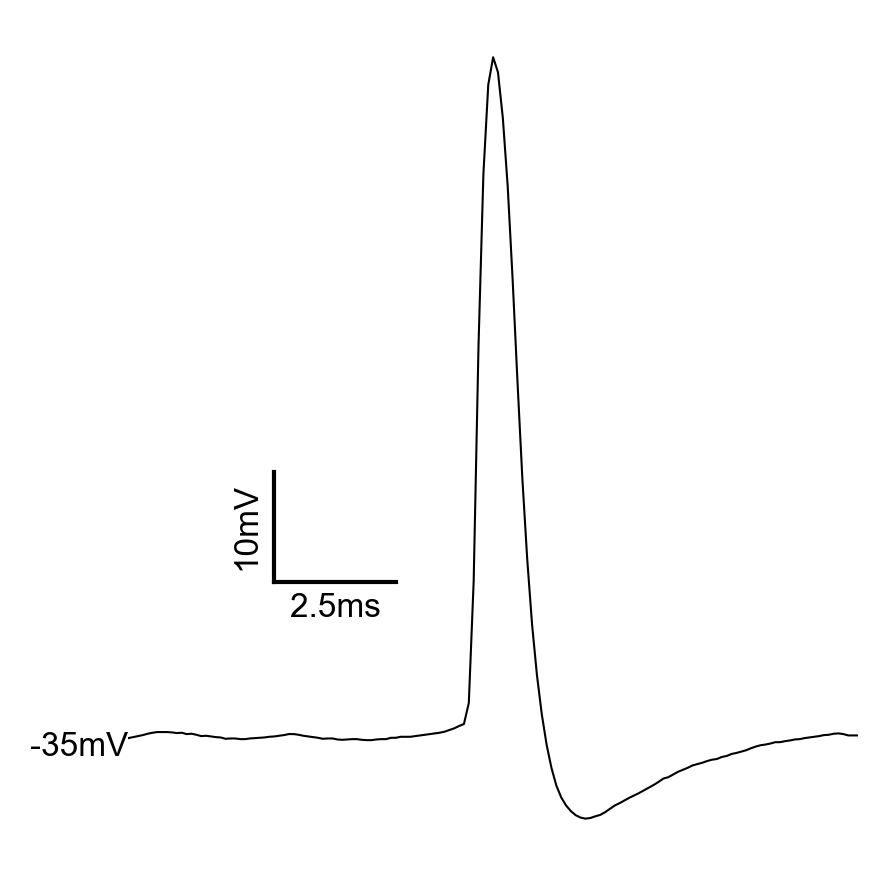

In [93]:
def single_ap(abf,linewidth=.5):
    fig,ax= plt.subplots(1,figsize=(3,3),dpi=300)
    v_range = [-45,30]
    t_range = [.275,.29]

    abf.setSweep(0,0)
    stim_color = 'k'
    time = abf.sweepX
    cmd = abf.sweepC
    memb = abf.sweepY
    memb = memb-memb[0]-70

    ax.set_xlim(t_range)
    ax.set_ylim(v_range)

    v0 = memb[  list(time).index(t_range[0])]
    v0 = int(np.round(v0/5,0)*5)

    trace_scalebar(ax=ax,origin=[.278,-20],x_unit='ms',y_unit='mV',x_len=2.5,y_len=10,x_rescale=1000,baseline=v0)
    ax.plot(time,memb,color=stim_color,linewidth=linewidth)

    plt.tight_layout()

    return None


single_ap(abf)


In [ ]:
for my_file in im_list:
    image = Image.open(my_file)
    image_array.append(image)